# Backbone notebook

Inspired by: http://nbviewer.jupyter.org/github/ademyanchuk/protein_atlas_baseline/blob/master/protein-1.ipynb



In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
# from fastai.utils.collect_env import *
# show_install(0)

In [ ]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('../tests/')
from challenge_setup import *


In [5]:
#open_image(path/'train_combined/79a6b502-bbb4-11e8-b2ba-ac1f6b6435d0.png')

In [5]:
np.random.seed(42)
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [6]:
bs = 64
sz = 64

In [7]:
src = (ImageFileList.from_folder(path)            
       .label_from_csv('train.csv', sep=' ', folder='train_combined', suffix='.png')  
       .random_split_by_pct(0.2))

In [8]:
# start with smaller size
data = (src.datasets()
        .transform(tfms, size=sz)
        .databunch(bs=bs).normalize(imagenet_stats))

In [9]:
#data.classes, data.c, len(data.train_ds), len(data.valid_ds)

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
    
def f1(y_pred, y_true, thresh:float=0.5, beta:float=1, eps:float=1e-9, sigmoid:bool=True):
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=0)
    prec = TP/(y_pred.sum(dim=0)+eps)
    rec = TP/(y_true.sum(dim=0)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

def f1_np(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred>threshold).astype(int)
    TP = (y_pred*y_true).sum(0)
    prec = TP/(y_pred.sum(0)+1e-7)
    rec = TP/(y_true.sum(0)+1e-7)
    res = 2*prec*rec/(prec+rec+1e-7)
    return res.mean()

def f1_n(y_pred, y_true, thresh, n, default=0.5):
    threshold = default * np.ones(y_pred.shape[1])
    threshold[n]=thresh
    return f1_np(y_pred, y_true, threshold)


# def f1(y_pred, y_true, thresh:float=0.5, beta:float=1, eps:float=1e-9, sigmoid:bool=True):
#     beta2 = beta**2
#     if sigmoid: y_pred = y_pred.sigmoid()
#     y_pred = (y_pred>thresh).float()
#     y_true = y_true.float()
#     TP = (y_pred*y_true).sum(dim=0)
#     prec = TP/(y_pred.sum(dim=0)+eps)
#     rec = TP/(y_true.sum(dim=0)+eps)
#     res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
#     return res.mean()
# def f1_(preds, targs, start=0.17, end=0.24, step=0.01):
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         return max([fbeta_score(targs, (preds>th), 1, average='samples')
#                     for th in np.arange(start,end,step)])

## Resnet 18 + 64

In [11]:
arch = models.resnet34

In [12]:
f1_score = partial(fbeta, thresh=0.2, beta=1.)
learn = create_cnn(data, arch,  metrics=[accuracy_thresh, f1 , f1_score]).to_fp16()


#learn = create_cnn(data, arch, metrics=[accuracy_thresh]).to_fp16()
#learn = create_cnn(data, arch).to_fp16()

learn.crit = FocalLoss()

In [13]:
#learn.data.valid_dl.add_tfm(to_half)
#learn.data.valid_dl.add_tfm(to_half)
#learn.model.float()
#learn.show_results()

## Save model after each epoch

In [14]:
# add save SaveModelCallback to save the model weights for every epoch
# learn.callback_fns.append(partial(SaveModelCallback, every='epoch', name='lung_inf_v4-ResNet34_stage-X_train-Y_epoch'))

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


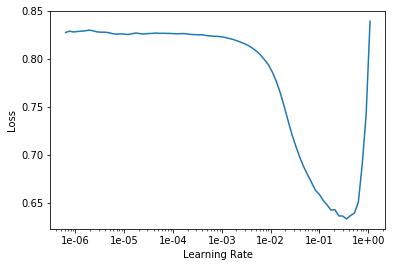

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 3e-2
learn.fit_one_cycle(5, slice(lr))

Total time: 04:50
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.162235    0.161647    0.946963         0.044186  0.353269  (00:58)
2      0.169004    0.163877    0.947118         0.038895  0.367051  (00:58)
3      0.160371    0.156922    0.948371         0.048698  0.392058  (00:58)
4      0.153497    0.155425    0.949222         0.062597  0.417478  (00:58)
5      0.150985    0.151640    0.949526         0.064807  0.422693  (00:58)



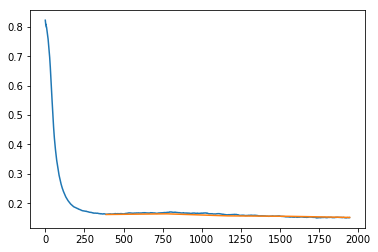

In [17]:
learn.recorder.plot_losses()

In [18]:
learn.save('stage-1-rn34-64')

## Unfreeze to train pretrained weights a bit

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


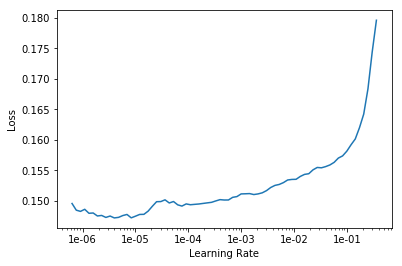

In [19]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

Total time: 04:52
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.150081    0.147986    0.949705         0.064409  0.425019  (00:58)
2      0.150443    0.155891    0.949245         0.064395  0.426329  (00:58)
3      0.148664    0.150632    0.949584         0.065188  0.428418  (00:58)
4      0.149469    0.146949    0.949963         0.065077  0.429185  (00:58)
5      0.150452    0.148724    0.949745         0.065231  0.428112  (00:58)



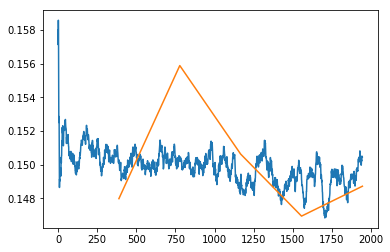

In [21]:
learn.recorder.plot_losses()

In [22]:
learn.save('stage-2-rn34-64')

## Resnet18 + 128

In [23]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

/home/fabsta/projects/deeplearning/fastai/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


torch.Size([3, 128, 128])

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


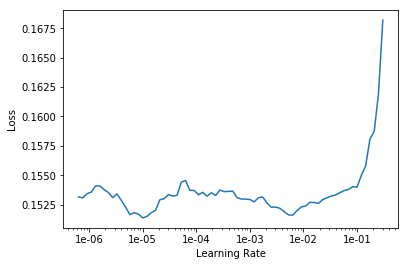

In [24]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [25]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))
learn.save('stage-1-rn34-128')

Total time: 05:19
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.147708    0.143194    0.951113         0.079812  0.452513  (01:03)
2      0.147835    0.144657    0.950693         0.075422  0.464268  (01:03)
3      0.143811    0.148922    0.951291         0.085163  0.463082  (01:04)
4      0.142102    0.139017    0.952009         0.089902  0.478068  (01:04)
5      0.139344    0.138396    0.952067         0.092154  0.475883  (01:03)



Total time: 05:24
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.143292    0.139211    0.951854         0.089407  0.477169  (01:05)
2      0.141933    0.138676    0.952377         0.100142  0.477949  (01:05)
3      0.138917    0.138142    0.952774         0.106494  0.490643  (01:04)
4      0.136866    0.143231    0.952688         0.114472  0.499599  (01:04)
5      0.135798    0.133281    0.953739         0.121409  0.506853  (01:05)



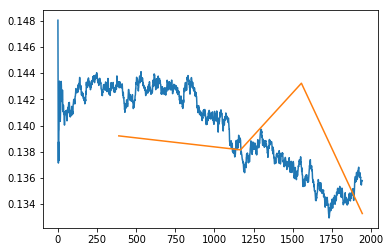

In [26]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))
learn.recorder.plot_losses()

In [27]:
learn.save('stage-2-rn34-128')

## Resnet18 + 256 

In [28]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


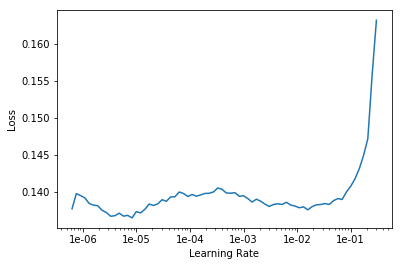

In [29]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [30]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))
learn.save('stage-1-rn34-256')

Total time: 08:04
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.131317    0.137883    0.954825         0.152823  0.530139  (01:37)
2      0.130771    0.126970    0.957015         0.178734  0.545205  (01:36)
3      0.126371    0.126817    0.957751         0.188498  0.560551  (01:36)
4      0.122466    0.120505    0.958717         0.204950  0.573617  (01:36)
5      0.121671    0.119959    0.959010         0.203770  0.575679  (01:36)



In [31]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 10:40
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.123191    0.168161    0.957377         0.203309  0.567298  (02:08)
2      0.119710    0.122357    0.958285         0.201950  0.568446  (02:07)
3      0.116875    0.115300    0.960383         0.230088  0.591939  (02:07)
4      0.110944    0.115112    0.961400         0.249099  0.609539  (02:07)
5      0.109502    0.111677    0.962125         0.255795  0.619428  (02:07)



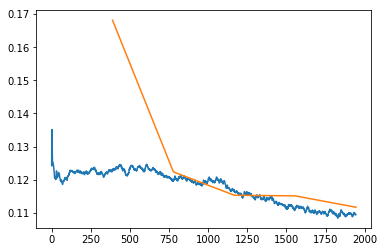

In [32]:
learn.recorder.plot_losses()
learn.save('stage-2-rn34-256')

## Resnet18 + 512

In [33]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=512)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


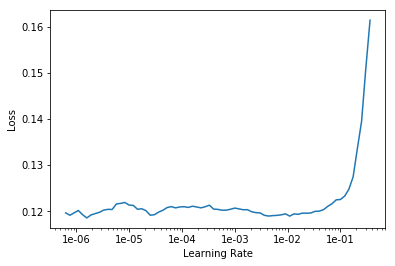

In [34]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [35]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))
learn.save('stage-1-rn34-512')

Total time: 28:34
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.106942    0.217130    0.955004         0.221883  0.587561  (05:46)
2      0.106503    0.115421    0.960401         0.259269  0.591873  (05:42)
3      0.103089    0.107064    0.963309         0.298685  0.634156  (05:42)
4      0.098742    0.102192    0.963843         0.299565  0.646304  (05:42)
5      0.098473    0.102342    0.964188         0.303549  0.649290  (05:42)



In [36]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 38:04
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.100857    0.106560    0.963401         0.281737  0.642952  (07:37)
2      0.102075    0.176340    0.961004         0.294623  0.633346  (07:36)
3      0.096111    0.099837    0.964447         0.306067  0.651934  (07:36)
4      0.089726    0.093506    0.966521         0.335389  0.675798  (07:36)
5      0.089800    0.091778    0.966878         0.346774  0.684225  (07:37)



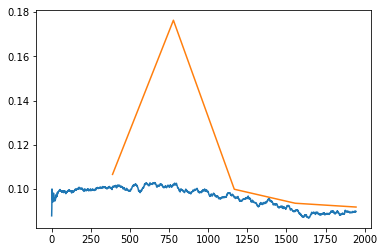

In [37]:
learn.recorder.plot_losses()
learn.save('stage-2-rn34-512')

In [38]:
p_v, t_v = learn.get_preds(DatasetType.Valid)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same

In [ ]:
p_v = p_v.numpy()
t_v = t_v.numpy()

In [ ]:
def sigmoid(a):
    return 1/(1+np.exp(-a))

In [ ]:
sp_v = sigmoid(p_v) #compute the sigmoid of the network output

In [ ]:
def f1_np(y_pred, y_true, threshold=0.5):
    '''numpy f1 metric'''
    y_pred = (y_pred>threshold).astype(int)
    TP = (y_pred*y_true).sum(1)
    prec = TP/(y_pred.sum(1)+1e-7)
    rec = TP/(y_true.sum(1)+1e-7)
    res = 2*prec*rec/(prec+rec+1e-7)
    return res.mean()


def f1_n(y_pred, y_true, thresh, n, default=0.5):
    '''partial f1 function for index n'''
    threshold = default * np.ones(y_pred.shape[1])
    threshold[n]=thresh
    return f1_np(y_pred, y_true, threshold)

def find_thresh(y_pred, y_true):
    '''brute force thresh finder'''
    ths = []
    for i in range(y_pred.shape[1]):
        aux = []
        for th in np.linspace(0,1,100):
            aux += [f1_n(y_pred, y_true, th, i)]
        ths += [np.array(aux).argmax()/100]
    return np.array(ths)

In [ ]:
ths = find_thresh(sp_v, t_v); ths

In [ ]:
f1_np(sp_v, t_v, 0.5), f1_np(sp_v, t_v, ths)

## Now the predictions

In [ ]:
preds_t = learn.TTA(scale=1.0, ds_type=DatasetType.Test, with_loss=False)[0]

In [ ]:
preds = sigmoid(preds_t.numpy())
threshold = ths
print(preds.shape)

In [23]:
# find optimal weight decay parameter
# from https://github.com/DrHB/fastai_wd/blob/master/wd_example.ipynb

@dataclass  
class wd_finder:
    #learner
    #wd, can be a single value or a tuple
    # if no wd is passed it will use standard wds 
    
    learn: Learner
    wd:Union[int,Callable]=None
    
    def __post_init__(self, **kwargs):
        self.wd_list = listify(self.wd)
        self.wd_recorder = []
        
        if self.wd is None:
            self.wd_list = [0, 1e-1, 1e-3, 1e-5]
            
        for wd in self.wd_list:
            self.learn.lr_find(wd=self.wd, **kwargs)
            self.wd_recorder.append(self.learn.recorder)
            
    def plot_wd(self, skip_start:int=10, skip_end:int=5)->None:
        _, ax = plt.subplots(1,1)
        
        for k, i in enumerate(self.wd_recorder):
            losses = i.losses[skip_start:-skip_end] if skip_end > 0 else i.losses[skip_start:]
            lrs = i.lrs[skip_start:-skip_end] if skip_end > 0 else i.lrs[skip_start:]
            ax.plot(lrs, losses, label='wd = {}'.format(self.wd_list[k]))
            ax.legend()
            ax.set_xscale('log')